# Part 3 - Predictive Modeling

What factors are the best predictors for rider retention?

## 1. Load, Clean, Explore Data

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier

### Load Data

In [18]:
#load json data
filepath = '../data/ultimate_data_challenge.json'

with open(filepath, "r") as f:
    data = json.load(f)

data[0]

{'city': "King's Landing",
 'trips_in_first_30_days': 4,
 'signup_date': '2014-01-25',
 'avg_rating_of_driver': 4.7,
 'avg_surge': 1.1,
 'last_trip_date': '2014-06-17',
 'phone': 'iPhone',
 'surge_pct': 15.4,
 'ultimate_black_user': True,
 'weekday_pct': 46.2,
 'avg_dist': 3.67,
 'avg_rating_by_driver': 5.0}

### Explore Data Structure / Clean

In [19]:
riders = pd.json_normalize(data)

riders.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [20]:
#look at dataframe info
riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


We have some missing data under avg_rating_of_driver, phone, and avg_rating_by_driver. I could see all of these being imporant factors in a retention model so we'll need to be intentional with how we address those missing records.

Column 1 and 5 should be updated to date types.

There is no target variable for retention. We can add this at some point. The description said this data was pulled 'several' months after January 2014 but we'll look at the 'last trip' measure and see if we can use that to estimate the date of the data run. This means we'll flag a rider as "retained" if they have had a ride in April 2014.

First let's look at the categorical variables:

### Categorical Variable Review

In [21]:
#values within 'city'
riders['city'].value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

In [22]:
#values within 'phone'
riders['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

Those both look consistent. We'll look over the data and boolean fields a bit later.

### Numerical Variable Review

In [23]:
riders.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


There are some definite outliers there in first 30 day trips, avg surge, surge %, and average distance - visual look:

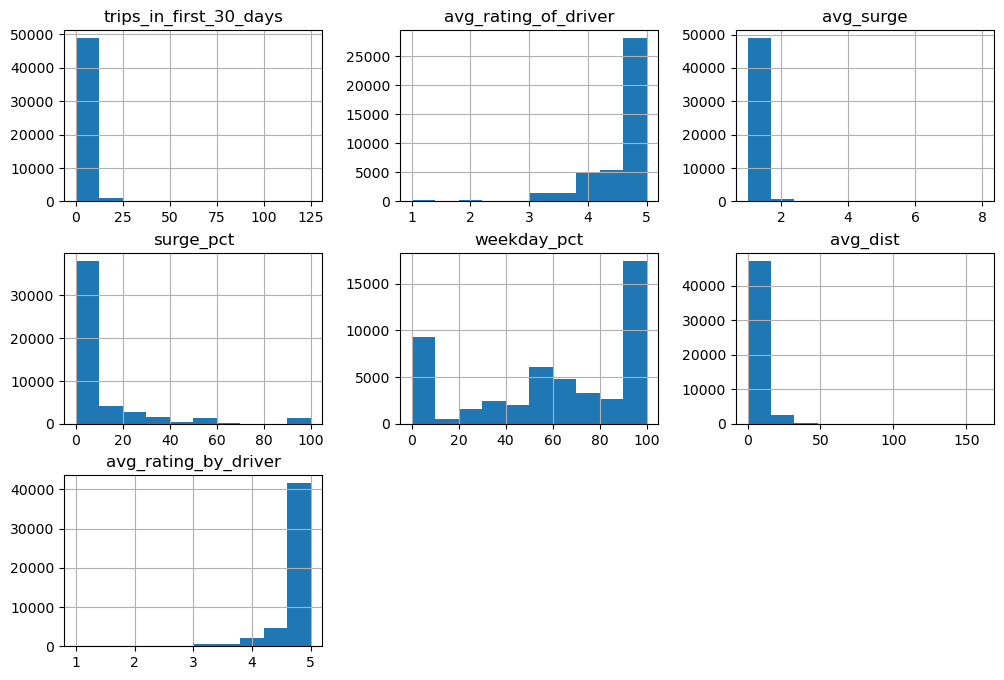

In [24]:
riders.hist(figsize=(12,8))

plt.show()

### Check for Duplicates

In [25]:
duplicates = riders[riders.duplicated(keep=False)]

duplicates

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
116,Winterfell,1,2014-01-10,5.0,1.0,2014-01-11,Android,0.0,False,100.0,0.00,5.0
332,Astapor,1,2014-01-18,5.0,1.0,2014-01-19,iPhone,0.0,True,0.0,6.25,5.0
2608,Astapor,1,2014-01-18,5.0,1.0,2014-01-19,iPhone,0.0,True,0.0,6.25,5.0
3134,Astapor,1,2014-01-20,5.0,1.0,2014-01-20,iPhone,0.0,False,100.0,3.06,5.0
5958,Winterfell,1,2014-01-18,NaN,1.0,2014-01-19,Android,0.0,False,0.0,0.01,5.0
7836,Astapor,1,2014-01-11,5.0,1.0,2014-01-11,iPhone,0.0,True,0.0,2.33,5.0
10624,Winterfell,1,2014-01-18,5.0,1.0,2014-01-19,Android,0.0,False,0.0,3.54,5.0
14990,Winterfell,1,2014-01-18,NaN,1.0,2014-01-19,iPhone,0.0,True,0.0,1.44,5.0
18057,Astapor,1,2014-01-11,5.0,1.0,2014-01-11,iPhone,0.0,True,0.0,2.33,5.0
26709,Winterfell,1,2014-01-01,NaN,1.0,2014-01-02,Android,0.0,False,100.0,8.08,5.0


In [26]:
duplicates.shape[0]

16

Without any sort of rider_id we can't know for sure if these data are incorrect duplicates, but it would be pretty rare to have exact matches. I will drop them.

In [27]:
print(riders.shape) #check number of rows
riders = riders.drop_duplicates() #drop dupes
print(riders.shape) #validate number of rows

(50000, 12)
(49992, 12)


Looks like a success, we had 8 pairs of duplicates, and that change dropped 8 values.

### Review Detail on Potential Outliers

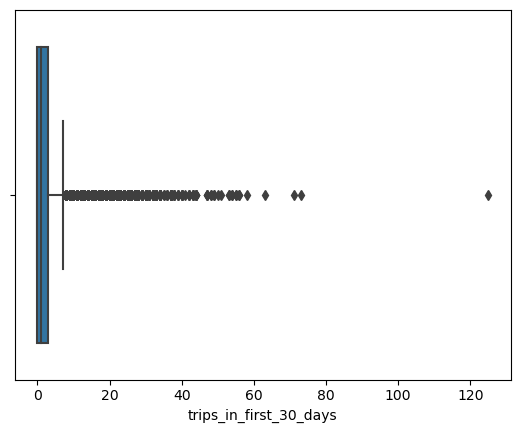

In [28]:
#rider is first 30 days boxplot
sns.boxplot(data=riders, x='trips_in_first_30_days')

plt.show()

In the boxplot sense, we see a lot of outliers with such a condensed IQR. Without being able to see the full ride details or talk with a business export, I could justify up to 60 if someone is commuting in and out of the city for 30 days straight but that would be a lot. Let's check those details.

In [29]:
#Trips in First 30 Days details
riders.loc[riders.trips_in_first_30_days > 12]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
38,King's Landing,24,2014-01-22,4.9,1.04,2014-06-30,iPhone,5.8,True,61.6,4.69,4.8
99,Astapor,73,2014-01-27,4.9,1.00,2014-03-05,Android,0.0,True,89.7,2.86,4.9
107,King's Landing,14,2014-01-07,4.9,1.09,2014-06-29,iPhone,15.9,False,50.0,10.79,4.9
200,Winterfell,22,2014-01-11,4.6,1.02,2014-06-29,iPhone,2.7,True,83.8,2.34,4.6
...,...,...,...,...,...,...,...,...,...,...,...,...
49518,Winterfell,20,2014-01-10,5.0,1.02,2014-06-30,iPhone,2.5,True,61.0,1.94,4.7
49601,King's Landing,14,2014-01-22,4.9,1.04,2014-06-30,Android,4.9,True,78.0,5.36,4.8
49756,King's Landing,21,2014-01-22,4.9,1.00,2014-06-26,iPhone,0.0,True,59.7,4.38,4.9
49841,Winterfell,13,2014-01-05,3.4,1.08,2014-02-24,iPhone,6.7,False,93.3,7.06,4.9


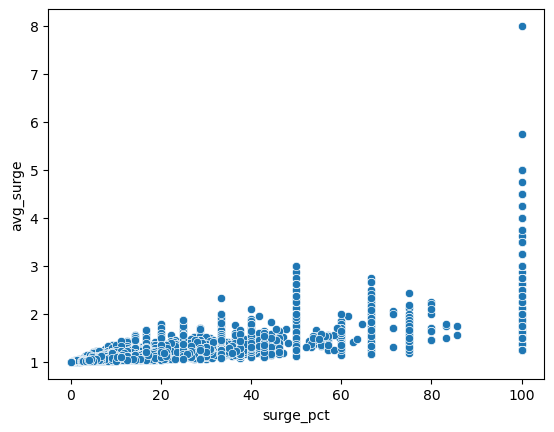

In [30]:
#avg surge and #surge_pct should relate, so let's look at those together
sns.scatterplot(data=riders, x='surge_pct', y='avg_surge')

plt.show()

Visually it looks like there is atleast one instance where surge_pct is > 0, but avg_surge is still 1. Let's look at that:

In [31]:
riders.loc[(riders.surge_pct>0) & (riders.avg_surge ==1)].head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
96,Winterfell,11,2014-01-26,4.1,1.0,2014-07-01,iPhone,1.9,True,76.9,4.89,4.6
1385,King's Landing,11,2014-01-02,5.0,1.0,2014-06-22,iPhone,1.9,True,61.1,1.78,4.8
3584,Astapor,5,2014-01-30,4.8,1.0,2014-06-28,iPhone,2.0,True,92.0,2.18,4.7
4726,Winterfell,11,2014-01-23,4.9,1.0,2014-06-28,iPhone,0.9,True,66.4,2.34,4.7
4847,Winterfell,18,2014-01-06,3.9,1.0,2014-06-30,iPhone,1.5,True,81.8,3.47,4.9


In [32]:
#check for the opposite effect
riders.loc[(riders.surge_pct==0) & (riders.avg_surge >1)].head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver


These records don't make sense to me -> if a user has some surge their avg surge should be greater than 1. I'll likely drop these. But there are none with a surge > 1 and 0 surge_pct which is good.

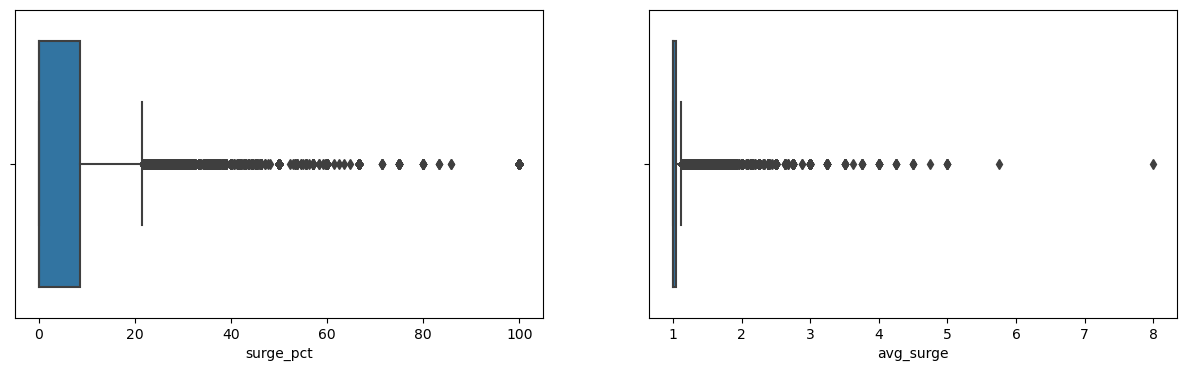

In [33]:
#view surge_pct & avg_surge together
fig, ax = plt.subplots(1, 2, figsize=(15,4))

sns.boxplot(ax=ax[0], data=riders, x='surge_pct')
sns.boxplot(ax=ax[1], data=riders, x='avg_surge')

plt.show()

I would say the 100% and 8 avg surge are big outliers. View those details.

In [34]:
riders.loc[(riders.surge_pct == 100)]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
28,Winterfell,0,2014-01-19,NaN,1.50,2014-06-08,iPhone,100.0,False,0.0,5.97,5.0
32,Winterfell,1,2014-01-05,4.0,2.00,2014-06-10,iPhone,100.0,False,100.0,10.01,5.0
34,Astapor,1,2014-01-16,NaN,1.25,2014-01-17,Android,100.0,False,100.0,4.12,5.0
42,Winterfell,1,2014-01-25,4.0,1.50,2014-01-26,Android,100.0,False,0.0,5.72,5.0
47,Winterfell,1,2014-01-18,5.0,1.25,2014-01-19,iPhone,100.0,False,0.0,3.61,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
49891,Astapor,0,2014-01-06,NaN,1.50,2014-03-30,iPhone,100.0,False,0.0,1.07,3.0
49894,Winterfell,0,2014-01-11,5.0,1.25,2014-02-21,iPhone,100.0,False,100.0,5.18,5.0
49928,Astapor,1,2014-01-04,5.0,2.00,2014-01-11,iPhone,100.0,False,100.0,0.58,5.0
49974,Winterfell,1,2014-01-05,5.0,2.00,2014-01-18,iPhone,100.0,False,100.0,4.63,5.0


1,416 rows is more than 2% of the overall data. This makes me think it's possible to only use during surge times. Which would make sense especially if they have limited trips overall. How about avg surge?

In [35]:
riders.loc[(riders.avg_surge > 2)]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
81,Winterfell,1,2014-01-25,4.0,3.50,2014-02-05,Android,100.0,True,100.0,17.89,4.0
119,Astapor,1,2014-01-11,NaN,2.50,2014-01-12,Android,100.0,False,0.0,4.14,5.0
197,Winterfell,0,2014-01-08,3.7,2.25,2014-03-02,iPhone,66.7,False,33.3,3.75,5.0
274,Astapor,1,2014-01-25,2.0,4.00,2014-02-09,iPhone,100.0,False,0.0,6.00,NaN
448,Astapor,0,2014-01-27,5.0,2.75,2014-03-19,Android,100.0,False,100.0,1.66,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
49402,King's Landing,0,2014-01-11,NaN,3.00,2014-03-21,iPhone,100.0,False,100.0,13.14,5.0
49563,Astapor,1,2014-01-20,5.0,3.00,2014-01-21,iPhone,100.0,False,100.0,1.30,5.0
49612,Winterfell,0,2014-01-22,NaN,2.38,2014-06-14,iPhone,100.0,False,0.0,3.08,5.0
49688,Astapor,0,2014-01-19,3.0,3.50,2014-03-29,iPhone,100.0,False,0.0,3.38,5.0


It's hard to know if these high levels are realistic. But some googling of what Uber does makes it seem like a possibility these are realistic surge numbers.

Last one: avg_dist

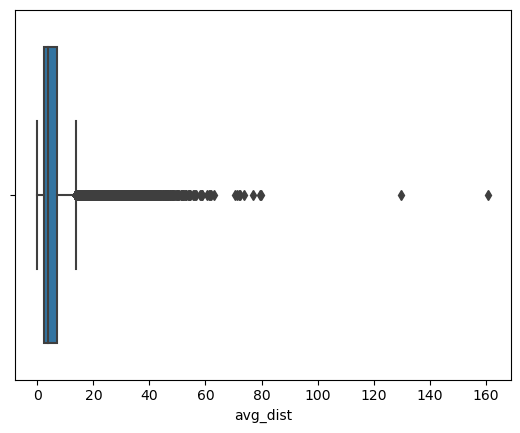

In [36]:
#rider is first 30 days boxplot
sns.boxplot(data=riders, x='avg_dist')

plt.show()

In [37]:
# the furthest two definitely jump out
riders.loc[riders.avg_dist >= 30]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
55,Winterfell,1,2014-01-04,4.0,1.0,2014-01-17,iPhone,0.0,False,100.0,36.01,5.0
73,Astapor,2,2014-01-19,5.0,1.0,2014-01-25,iPhone,0.0,False,0.0,37.11,5.0
320,Astapor,1,2014-01-08,5.0,1.0,2014-01-09,None,0.0,False,100.0,31.01,5.0
534,King's Landing,0,2014-01-04,NaN,1.0,2014-03-09,None,0.0,False,0.0,129.89,5.0
799,Astapor,0,2014-01-28,5.0,1.0,2014-05-15,Android,0.0,False,100.0,60.58,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
49614,Winterfell,1,2014-01-24,NaN,1.0,2014-02-07,iPhone,0.0,True,100.0,30.61,5.0
49698,King's Landing,0,2014-01-27,5.0,1.0,2014-05-29,iPhone,0.0,False,100.0,35.62,5.0
49808,King's Landing,0,2014-01-29,5.0,1.0,2014-06-18,Android,0.0,True,100.0,46.85,5.0
49812,Astapor,0,2014-01-07,NaN,1.0,2014-02-11,iPhone,0.0,False,100.0,38.72,5.0


Similar to the other metrics, it's impossible to tell if these are incorrect.

### Numerical Review Observations

Just because we don't know if data is just plain incorrect, doesn't mean we can't address it. I want to try to find a balance that removes outliers that will mess up the model, but still allow data that makes some business sense. So for cleanup I will:
- Drop 1st 30 day trips > 12. I could see examples being possible to use upwards of the high numbers in the data, but they likely aren't representative of most of our current or future users. 12 feels like a good compromise at around 3x the standard deviation from the mean.
- Drop records with a surge_pct > 0 but avg_surge==1
- Drop avg_surg >=3 to allow for users that run mostly during surge times, but get rid of some of the more extreme values and adjust for the fact that users consistently purchasing during surge aren't representative of most of our user base.
- Drop avg_g distance >= 30. This will allow for more than 3 std deviations from the mean, but without knowing the location of airports to the city, it feel like it makes business sense to allow some extra room for frequent travelers.

### Implement Changes

In [38]:
rider_df = riders.copy() #create copy to adjust

#create mask
mask = rider_df.trips_in_first_30_days>12

#drop
rider_df = rider_df[~mask] #only values not in mas

In [39]:
#drop surge records with avg_surg==1 but a surge % > 0

#create mask
mask1 = (rider_df.surge_pct>0) & (rider_df.avg_surge==1)

#drop
rider_df = rider_df[~mask1] #only save values that aren't in mask

In [40]:
#drop avg_surg > 2

#create mask
mask2 = rider_df.avg_surge>2

#drop
rider_df = rider_df[~mask2]

In [41]:
#drop avg_dist >= 30

#create mask
mask3 = rider_df.avg_dist>=30

rider_df = rider_df[~mask3]

In [42]:
#view new shape
rider_df.shape

(47859, 12)

### Update Date Types

In [43]:
rider_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47859 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    47859 non-null  object 
 1   trips_in_first_30_days  47859 non-null  int64  
 2   signup_date             47859 non-null  object 
 3   avg_rating_of_driver    40067 non-null  float64
 4   avg_surge               47859 non-null  float64
 5   last_trip_date          47859 non-null  object 
 6   phone                   47488 non-null  object 
 7   surge_pct               47859 non-null  float64
 8   ultimate_black_user     47859 non-null  bool   
 9   weekday_pct             47859 non-null  float64
 10  avg_dist                47859 non-null  float64
 11  avg_rating_by_driver    47668 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.4+ MB


In [44]:
#convert using to_datetime as part of pandas
rider_df['signup_date'] = pd.to_datetime(rider_df['signup_date'])

rider_df['last_trip_date'] = pd.to_datetime(rider_df['last_trip_date'])

In [45]:
rider_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47859 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    47859 non-null  object        
 1   trips_in_first_30_days  47859 non-null  int64         
 2   signup_date             47859 non-null  datetime64[ns]
 3   avg_rating_of_driver    40067 non-null  float64       
 4   avg_surge               47859 non-null  float64       
 5   last_trip_date          47859 non-null  datetime64[ns]
 6   phone                   47488 non-null  object        
 7   surge_pct               47859 non-null  float64       
 8   ultimate_black_user     47859 non-null  bool          
 9   weekday_pct             47859 non-null  float64       
 10  avg_dist                47859 non-null  float64       
 11  avg_rating_by_driver    47668 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [46]:
#check max and min dates
print(rider_df['signup_date'].min(), rider_df['signup_date'].max())
print(rider_df['last_trip_date'].min(), rider_df['last_trip_date'].max())

2014-01-01 00:00:00 2014-01-31 00:00:00
2014-01-01 00:00:00 2014-07-01 00:00:00


This looks consistent with what we know about the data.

### Re-Check Shape to See Impact of Dropped Outliers

In [47]:
rider_df.shape

(47859, 12)

It looks like I've dropped about 2,141 rows in the cleaning (leaving 96% of the original 50,000 records).

## 2A. Feature Engineering


### Encode Ultimate User Field
I want to start by changing our ultimate_black_user feld to be a 1 and 0 rather than True/False, which will be best for modeling.

In [29]:
rider_df['ultimate_black_user'].value_counts()

False    30007
True     17860
Name: ultimate_black_user, dtype: int64

In [30]:
#convert to 1 & 0
rider_df.loc[rider_df.ultimate_black_user == True, 'ultimate_black_user'] = 1
rider_df.loc[rider_df.ultimate_black_user == False, 'ultimate_black_user'] = 0

In [31]:
#validate values
rider_df['ultimate_black_user'].value_counts()

0    30007
1    17860
Name: ultimate_black_user, dtype: int64

### Add Account Age Field

I also want to add an account_age field in days. We know from earlier the max ride date was 7/1, so I'll assume the data was pulled on 7/1.

In [32]:
#save report date variable
report_date = datetime.strptime('7/1/14', '%m/%d/%y')

report_date

datetime.datetime(2014, 7, 1, 0, 0)

In [33]:
rider_df['account_age_days'] = (report_date - rider_df['signup_date']).dt.days

rider_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,account_age_days
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,1,46.2,3.67,5.0,157
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,0,50.0,8.26,5.0,153
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,0,100.0,0.77,5.0,176
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,1,80.0,2.36,4.9,172
5,Winterfell,2,2014-01-09,3.5,1.00,2014-06-06,iPhone,0.0,1,100.0,10.56,5.0,173


### Breakout Dates into New Variables - Weekday

I'm not sure if this will be valuable, but worth a shot. I won't breakout into full day, month, year because we have a small window of time and I don't believe there is enough of date range to make that level of detail valuable.

In [34]:
#create using dt and save as type 'object' since it isn't a continuous variable

rider_df['signup_weekday'] = rider_df['signup_date'].dt.dayofweek.astype(object)
rider_df['last_trip_weekday'] = rider_df['last_trip_date'].dt.dayofweek.astype(object)

rider_df.head(3)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,account_age_days,signup_weekday,last_trip_weekday
0,King's Landing,4,2014-01-25,4.7,1.1,2014-06-17,iPhone,15.4,1,46.2,3.67,5.0,157,5,1
1,Astapor,0,2014-01-29,5.0,1.0,2014-05-05,Android,0.0,0,50.0,8.26,5.0,153,2,0
2,Astapor,3,2014-01-06,4.3,1.0,2014-01-07,iPhone,0.0,0,100.0,0.77,5.0,176,0,1


### Add Target Variable

We can use 7/1/14 as the data pull date, so let's say if a user has a trip on or after 6/1/14 they can be flagged as "retained"

In [35]:
#create new column "trip_in_last_30_days" using np.where function

rider_df['trip_in_last_30_days'] = np.where(rider_df.last_trip_date>='2014-06-01', 1, 0) #return a 1 if they've had a trip since June 1, 2014 - else return 0

rider_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,account_age_days,signup_weekday,last_trip_weekday,trip_in_last_30_days
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,1,46.2,3.67,5.0,157,5,1,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,0,50.0,8.26,5.0,153,2,0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,0,100.0,0.77,5.0,176,0,1,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,1,80.0,2.36,4.9,172,4,6,1
5,Winterfell,2,2014-01-09,3.5,1.00,2014-06-06,iPhone,0.0,1,100.0,10.56,5.0,173,3,4,1


In [36]:
#validate results
print(rider_df.loc[rider_df.trip_in_last_30_days==1]['last_trip_date'].min()) #expecting 6/1
print(rider_df.loc[rider_df.trip_in_last_30_days==0]['last_trip_date'].max()) #expecting 5/31

2014-06-01 00:00:00
2014-05-31 00:00:00


In [37]:
#what percentage were not retained?
rider_df.loc[rider_df.trip_in_last_30_days==0].shape[0] / rider_df.shape[0]

0.629619570894353

### Drop Original Data Columns

I broke out the feature I care most about so I don't want the full date anymore.

In [38]:
rider_df.drop(columns=['signup_date','last_trip_date'], inplace=True)

### Check correlation matrix

/var/folders/_z/9zltq2bj1dz1k05g4mtz4gq00000gn/T/ipykernel_32181/2378041993.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrMatrix = rider_df.corr() #do not include lat & lon


[]

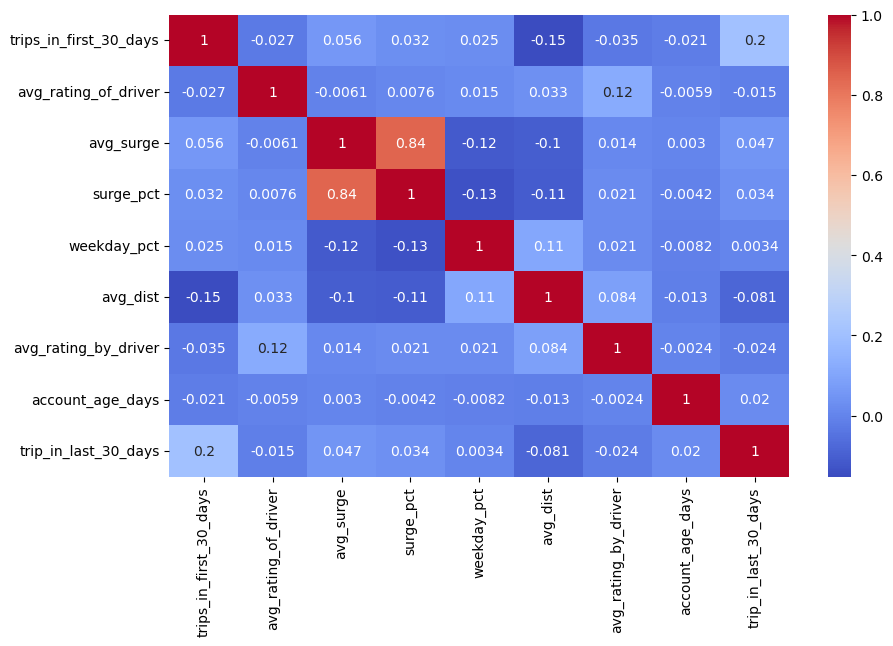

In [39]:
#create variable with values
corrMatrix = rider_df.corr() #do not include lat & lon

fig, ax = plt.subplots(figsize=(10,6))

#plot with seaborn
sns.heatmap(corrMatrix, annot=True, cmap='coolwarm')

plt.plot()

## 2B. Pre-Processing

I'll split the train and test data and then performing scaling, transformation, imputes, etc.

### Train-Test Split

In [40]:
#I'll use an 80-20 split
X_train, X_test, y_train, y_test = train_test_split(rider_df.drop(columns='trip_in_last_30_days'), #drop target feature from X
                                                    rider_df.trip_in_last_30_days, #target feature only for y
                                                    test_size=0.2,
                                                    random_state=42)

In [41]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(38293, 13) (9574, 13)
(38293,) (9574,)


In [42]:
#double check dtypes in X one more time
X_train.dtypes

city                       object
trips_in_first_30_days      int64
avg_rating_of_driver      float64
avg_surge                 float64
phone                      object
surge_pct                 float64
ultimate_black_user        object
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
account_age_days            int64
signup_weekday             object
last_trip_weekday          object
dtype: object

### Create Pipeline for Pre-Processing

I want to seperate into categorical vs. numerical with these proessing steps:
1. Imputing for missing variables. Using the most common value for any categorical and the median for any numerical.
2. OneHotEncode categorical variables
3. Use StandardScaler on numerical variables

I'm going to leave the date fields and the ultimate_black_user as passing through without processing -> I want to leave those as is as the ultimate user is already encoded. And I don't want to scale dates.

Big shoutout to this blog post: https://medium.com/analytics-vidhya/how-to-apply-preprocessing-steps-in-a-pipeline-only-to-specific-features-4e91fe45dfb8

In [43]:
#which variables have missing values?
rider_df.isna().sum()

city                         0
trips_in_first_30_days       0
avg_rating_of_driver      7795
avg_surge                    0
phone                      371
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       191
account_age_days             0
signup_weekday               0
last_trip_weekday            0
trip_in_last_30_days         0
dtype: int64

In [44]:
#transformer for categorical variables
cat_features = ['city','phone','signup_weekday','last_trip_weekday']
cat_transformer = Pipeline(
    [
        ('imputer_cat', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

In [45]:
#transformer for numerical variables
num_features = ['trips_in_first_30_days','avg_rating_of_driver','avg_surge', 'surge_pct','weekday_pct','avg_dist','avg_rating_by_driver','account_age_days']
num_transformer = Pipeline(
    [
        ('imputer_num', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

In [46]:
#combine in Column Transformer
preprocessor = ColumnTransformer(
    [
        ('categoricals', cat_transformer, cat_features),
        ('numericals', num_transformer, num_features)
    ],
    remainder='passthrough'
)

In [47]:
#create a pipeline using our pre-processing column transforming and a Logistic Regrssion model
pipe = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('clf', LogisticRegression())
    ]
)

With a pipeline setup, we'll setup some parameters to do a GridSearch cross-validation for tuning hyperparameters

### Hyperparameter Tuning

In [48]:
#setup parameters to test for a logistic regression model
params = {
    'clf__solver': ['liblinear'],
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__random_state': [42]
}

In [49]:
#setup a cross_validation method using repeat stratified k fold
cvstrat = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

In [50]:
#create our GridSearch object. I am thinking our evaluation measure would be best suited as precision. I want to penalize the model for predicting retention whne it isn't the case. But I will include f1 in the scoring and refit based on precision
cv = GridSearchCV(
    pipe,
    params,
    cv = cvstrat,
    scoring = ['precision', 'f1'],
    refit = 'precision'
)

In [51]:
#execute our GridSearch on the trainign data and check results
cv.fit(X_train, y_train)

print(f'Best Precision Score: {cv.best_score_:.3f}\n')
print(f'Best parameter set: {cv.best_params_}\n')
print(f'Scores: {classification_report(y_train, cv.predict(X_train))}')

Best Precision Score: 0.676

Best parameter set: {'clf__C': 0.01, 'clf__penalty': 'l1', 'clf__random_state': 42, 'clf__solver': 'liblinear'}

Scores:               precision    recall  f1-score   support

           0       0.74      0.87      0.80     24132
           1       0.68      0.47      0.55     14161

    accuracy                           0.72     38293
   macro avg       0.71      0.67      0.68     38293
weighted avg       0.71      0.72      0.71     38293



**Observations**
87% recall is good, meaning this predicts 87% of the total churn correctly. But I hope the positive class precision of 67.6% could be increased. That low of a figure would likely lead to some unecessary costs of interventions to prevent churn that would not happen (and maybe even end up increasing it!)

## 2C. Further Modeling and Testing

I want to test out random forest classifier to see if it performs better

### Random Forest Classifier

I'll setup a new pipeline with a randomforest model and check the results.

In [52]:
#create copies of training sets

X_train_rf = X_train
y_train_rf = y_train

In [53]:
#create a pipeline using our pre-processing column transforming and a Logistic Regrssion model
pipe_rf = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('clf_rf', RandomForestClassifier())
    ]
)

In [54]:
#establish params to test
grid_params_rf = [{'clf_rf__criterion': ['gini', 'entropy'], # measures split quality
                   'clf_rf__n_estimators': [50, 100, 200], # number trees to grow            
                   'clf_rf__max_features': ['sqrt'], # features considered at splits
                   'clf_rf__max_depth': [4, 6, 8, 10],  # max nodes in each tree
                   'clf_rf__min_samples_leaf': [1, 5], # samples required in each leaf
                   'clf_rf__min_samples_split': [0.1, 0.2, 0.3, 0.4], # percentage required to split node
                   'clf_rf__random_state': [42]
                    }]

In [55]:
#establish params to test - substitue with best params to run again
#grid_params_rf = [{'clf_rf__criterion': ['gini'], # measures split quality
#                   'clf_rf__n_estimators': [200], # number trees to grow            
#                   'clf_rf__max_features': ['sqrt'], # features considered at splits
#                   'clf_rf__max_depth': [4],  # max nodes in each tree
#                   'clf_rf__min_samples_leaf': [1], # samples required in each leaf
#                   'clf_rf__min_samples_split': [0.4], # percentage required to split node
#                   'clf_rf__random_state': [42]
#                    }]

In [56]:
#establish gridsearch object
cv_rf = GridSearchCV(
    pipe_rf,
    grid_params_rf,
    cv = cvstrat,
    scoring = ['precision', 'f1'],
    refit = 'precision'
)

In [57]:
#execute our GridSearch on the trainign data and check results
cv_rf.fit(X_train_rf, y_train_rf)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=42),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categoricals',
                                                                         Pipeline(steps=[('imputer_cat',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['city',
                                                                          'phone',
                                                                          'signup_weekday...
                                                                          'avg_rating_by_driver',
                                                                          'account_age_days'])])),
                                       ('clf_rf', RandomForestClassifier())]),
             param_grid=[{'clf_rf__criterion': ['gini'],
                          'clf_rf__max_depth': [4],
                          'clf_rf__max_features': ['sqrt'],
                          'clf_rf__min_samples_leaf': [1],
                          'clf_rf__min_samples_split': [0.4],
                          'clf_rf__n_estimators': [200],
                          'clf_rf__random_state': [42]}],
             refit='precision', scoring=['precision', 'f1'])

In [58]:
print(f'Best Precision Score: {cv_rf.best_score_:.3f}\n')
print(f'Best parameter set: {cv_rf.best_params_}\n')
print(f'Scores: {classification_report(y_train_rf, cv_rf.predict(X_train_rf))}')

Best Precision Score: 0.804

Best parameter set: {'clf_rf__criterion': 'gini', 'clf_rf__max_depth': 4, 'clf_rf__max_features': 'sqrt', 'clf_rf__min_samples_leaf': 1, 'clf_rf__min_samples_split': 0.4, 'clf_rf__n_estimators': 200, 'clf_rf__random_state': 42}

Scores:               precision    recall  f1-score   support

           0       0.70      0.96      0.81     24132
           1       0.80      0.29      0.42     14161

    accuracy                           0.71     38293
   macro avg       0.75      0.62      0.61     38293
weighted avg       0.74      0.71      0.66     38293



**Observations:**
This are much better results in some of the areas, but my guess is there is some overfitting going on.

## 2D. Test Data

Let's see how this applies to test data.

I'll use some useful functions found on a blog to present the classification in a prettier way. Thank you, https://github.com/cutterback/p03-telco-churn-model/blob/master/Telco-Churn-Classification-Model.ipynb

In [59]:
# plot confusion matrix for classifier object
def display_class_report(y_true, y_hat):
    """Prints classification report for a classifier model predictions.

    Parameters:
    - y_true (pd.Series): true north y values (actual churn values)
    - y_hat (array): model predictions for y    

    Returns: none
    """
    print(pd.DataFrame(confusion_matrix(y_true, y_hat),
                       columns=['Churn Pred', 'Retain Pred'], 
                       index=['Churn Actual', 'Retain Actual']))
    print(classification_report(y_true, y_hat))

In [60]:
# calculates model evaluation metrics by comparing predictions to "true north"
def score_pred(model_type, data_type, y_true, y_hat):
    """Calculates and returns ROC AUC, accuracy, recall, precision, f1 score; 
    prints compact results summary.

    Parameters:
    - model_type (str): identifes type of model (eg. 'rf' = random forest)
    - data_type (str): indicates if y values are from train or test results
    - y_true (pd.Series): true north y values (actual churn values)
    - y_hat (array): model predictions for y

    Returns:
    - scores (dict): includes 5 evaluation metrics for model type
    """
    scores = {}
    scores['model'] = model_type
    scores['data'] = data_type
    scores['auc'] = roc_auc_score(y_true, y_hat)
    scores['acc'] = accuracy_score(y_true, y_hat)
    scores['rec'] = recall_score(y_true, y_hat)
    scores['prec'] = precision_score(y_true, y_hat)
    scores['f1'] = f1_score(y_true, y_hat)   
    print(f'Model {scores["model"]} Predictions: AUC {round(scores["auc"], 2)} | '
          f'Accuracy {round(scores["acc"], 2)} | '
          f'Recall {round(scores["rec"], 2)} | '
          f'Precision {round(scores["prec"], 2)} | '
          f'F1 {round(scores["f1"], 2)}' )

    return scores

### Logistic Regression

In [61]:
#Compare best estimators for train vs. test
print('Train Performance - Logistic Regression\n---------------------------------')
y_pred_train = cv.predict(X_train)
scores_train_lr = score_pred('lr', 'train', y_train, y_pred_train)

print('\nTest Performance - Logistic Regression\n--------------------------------')
y_pred_test = cv.predict(X_test)
scores_test_lr = score_pred('lr', 'test', y_test, y_pred_test)

print('\nTrain Classification Report\n--------------------------------')
print(f'Scores: {classification_report(y_train, y_pred_train)}')

print('\nTest Classification Report\n--------------------------------')
print(f'Scores: {classification_report(y_test, y_pred_test)}')


Train Performance - Logistic Regression
---------------------------------
Model lr Predictions: AUC 0.67 | Accuracy 0.72 | Recall 0.47 | Precision 0.68 | F1 0.55

Test Performance - Logistic Regression
--------------------------------
Model lr Predictions: AUC 0.67 | Accuracy 0.72 | Recall 0.47 | Precision 0.67 | F1 0.55

Train Classification Report
--------------------------------
Scores:               precision    recall  f1-score   support

           0       0.74      0.87      0.80     24132
           1       0.68      0.47      0.55     14161

    accuracy                           0.72     38293
   macro avg       0.71      0.67      0.68     38293
weighted avg       0.71      0.72      0.71     38293


Test Classification Report
--------------------------------
Scores:               precision    recall  f1-score   support

           0       0.73      0.86      0.79      6006
           1       0.67      0.47      0.55      3568

    accuracy                           0.72    

The Training to Test performance is consistent which is great. Let's check this for our RF model.

### Random Forest Classifier

In [62]:
#Compare best estimators for train vs. test
print('Train Performance - Random Forest\n---------------------------------')
y_pred_train_rf = cv_rf.predict(X_train_rf)
scores_train_rf = score_pred('rf', 'train', y_train_rf, y_pred_train_rf)

print('\nTest Performance - Random Forest\n--------------------------------')
y_pred_test_rf = cv_rf.predict(X_test)
scores_test_rf = score_pred('rf', 'test', y_test, y_pred_test_rf)

print('\nTrain Classification Report\n--------------------------------')
print(f'Scores: {classification_report(y_train_rf, y_pred_train_rf)}')

print('\nTest Classification Report\n--------------------------------')
print(f'Scores: {classification_report(y_test, y_pred_test_rf)}')


Train Performance - Random Forest
---------------------------------
Model rf Predictions: AUC 0.62 | Accuracy 0.71 | Recall 0.29 | Precision 0.8 | F1 0.42

Test Performance - Random Forest
--------------------------------
Model rf Predictions: AUC 0.63 | Accuracy 0.71 | Recall 0.3 | Precision 0.82 | F1 0.44

Train Classification Report
--------------------------------
Scores:               precision    recall  f1-score   support

           0       0.70      0.96      0.81     24132
           1       0.80      0.29      0.42     14161

    accuracy                           0.71     38293
   macro avg       0.75      0.62      0.61     38293
weighted avg       0.74      0.71      0.66     38293


Test Classification Report
--------------------------------
Scores:               precision    recall  f1-score   support

           0       0.70      0.96      0.81      6006
           1       0.82      0.30      0.44      3568

    accuracy                           0.71      9574
   macr

Both actually apply to the test set pretty well. But with our random forest model having such a high recall on 0 class and higher precision on 1 class I think it is the superior choice.

## 3. Model Report

Random Forest Confusion Matrix - Test Data - Best Model 0


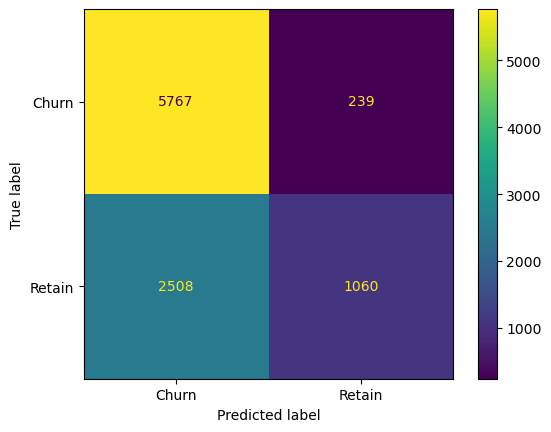

               Churn Pred  Retain Pred
Churn Actual         5767          239
Retain Actual        2508         1060
              precision    recall  f1-score   support

           0       0.70      0.96      0.81      6006
           1       0.82      0.30      0.44      3568

    accuracy                           0.71      9574
   macro avg       0.76      0.63      0.62      9574
weighted avg       0.74      0.71      0.67      9574



In [64]:
# print confusion matrix for best Logistic Regression model on test data
best_model_rf = cv_rf.best_estimator_._final_estimator
print(f'Random Forest Confusion Matrix - Test Data - Best Model {cv_rf.best_index_}')
cm = confusion_matrix(y_test, y_pred_test_rf, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Churn', 'Retain'])
disp.plot()
plt.show()

display_class_report(y_test, y_pred_test_rf)

In [65]:
best_model_rf

RandomForestClassifier(max_depth=4, min_samples_split=0.4, n_estimators=200,
                       random_state=42)

In [100]:
best_pipeline = cv_rf.best_estimator_

# Extract the random forest model from the pipeline
type(best_pipeline.named_steps)

sklearn.utils._bunch.Bunch

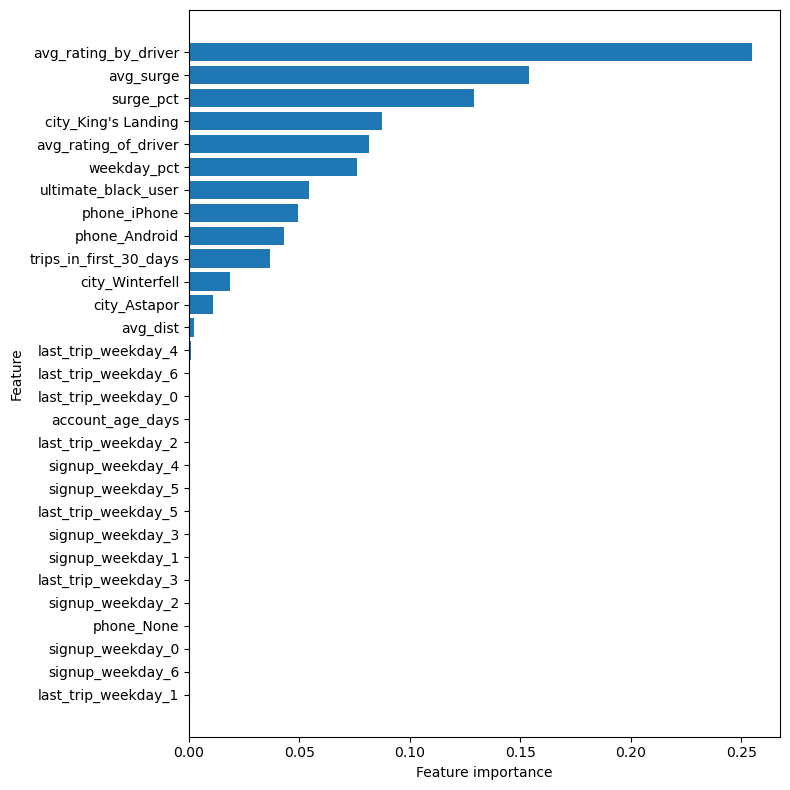

In [108]:
# Get the best estimator from RandomizedSearchCV
best_pipeline = cv_rf.best_estimator_

# Find the position of the 'clf_rf' step in the pipeline
clf_rf_index = [i for i, step in enumerate(best_pipeline.steps) if step[0] == 'clf_rf'][0]

# Extract the OneHotEncoder from the pipeline
encoder = best_pipeline.steps[clf_rf_index-1][1]

# Extract the random forest model from the pipeline
best_model_rf = best_pipeline.steps[clf_rf_index][1]

# Get the column names of the encoded features
encoded_feature_names = encoder.get_feature_names_out(input_features=X_test.columns)

# Extract the feature importances from the best model
feature_importances = best_model_rf.feature_importances_

# Remove the leading 'categorical__' and 'numerical__' prefixes
cleaned_feature_names = np.array([name.split('__')[-1] for name in encoded_feature_names])

# Sort the feature importances and feature names in ascending order
sorted_indices = np.argsort(feature_importances)
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = cleaned_feature_names[sorted_indices]

# Plot the feature importances
plt.figure(figsize=(8, 8))
plt.barh(range(len(sorted_feature_names)), sorted_feature_importances, align='center') 
plt.yticks(np.arange(len(sorted_feature_names)), sorted_feature_names) 
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
